In [1]:
import random

from sonify import play_midi_from_data, scale_list_to_range

import sonify

import scipy.signal
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

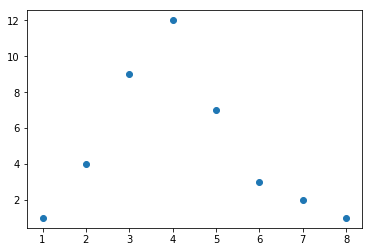

In [2]:
# Get the data we'd like to play from
simple_data = [(1, 1), (2, 4), (3, 9), (4, 12), (5, 7), (6, 3), (7, 2), (8, 1)]

plt.scatter(*zip(*simple_data))

In [3]:
play_midi_from_data(simple_data)

Finished!


In [4]:
play_midi_from_data(simple_data, key='c_major')

Finished!


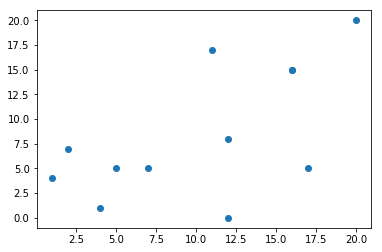

In [5]:
# Generate some random data

new_data = []
for i in range(0, 12):
    new_data.append((random.randint(0, 20), random.randint(0, 20)))
    
plt.scatter(*zip(*new_data))

In [ ]:
play_midi_from_data(new_data)

In [ ]:
def get_and_process_kepler_data():
    """
    Example from @GeertHub's talk on "How to find a planet"
    http://nbviewer.jupyter.org/github/barentsen/how-to-find-a-planet/blob/master/how-to-find-a-planet.ipynb
    """
    import astropy.io.fits
    from astropy.stats import LombScargle
    # Read in Kepler data for star number 011904151
    data = astropy.io.fits.open("https://archive.stsci.edu/missions/kepler/target_pixel_files/0119/011904151/kplr011904151-2010009091648_lpd-targ.fits.gz")[1].data
    time = data["TIME"][data['QUALITY'] == 0]
    images = data["FLUX"][data['QUALITY'] == 0]
    
    lightcurve = np.sum(images, axis=(1, 2))
    trend = scipy.signal.savgol_filter(lightcurve, 101, polyorder=3) 
    percent_change = 100 * ((lightcurve / trend) - 1)

    frequency, power = LombScargle(time, percent_change, nterms=2).autopower(minimum_frequency=1/1.5, maximum_frequency=1/0.6, samples_per_peak=10)
    period = 1 / frequency[np.argmax(power)]
    
    x_points = []
    y_points = []
    for i in range(10):
        mask = (time >= time[0] + i*period) & (time < time[0] + (i+1)*period)
        x_points += [x for x in time[mask] - time[0] - i*period]
        y_points += [y for y in percent_change[mask]]

    normalized_x = scale_list_to_range(x_points, new_min=0, new_max=30)
    normalized_y = scale_list_to_range(y_points, new_min=0, new_max=30)

    normed_data = list(zip(normalized_x, normalized_y))
    
    return normed_data

In [ ]:
normed_data = get_and_process_kepler_data()

plt.scatter(*zip(*normed_data)) 

In [ ]:
play_midi_from_data(normed_data, key='c_major')